In [1]:
from pathlib import Path
import numpy as np

import quantem as em
from quantem.core import config
from quantem.core.datastructures import Dataset4dstem
from quantem.diffractive_imaging.dataset_models import PtychographyDatasetRaster
# from quantem.diffractive_imaging.pftm import PFTM, PFTM_DIP
from quantem.core.visualization import show_2d

from quantem.core import config
from quantem.core.datastructures import Dataset4dstem
from quantem.core.visualization.visualization import show_2d
from quantem.diffractive_imaging.dataset_models import PtychographyDatasetRaster
from quantem.diffractive_imaging.detector_models import DetectorPixelated
from quantem.diffractive_imaging.object_models import ObjectDIP, ObjectPixelated
from quantem.diffractive_imaging.probe_models import ProbePixelated
from quantem.diffractive_imaging.ptychography import Ptychography
from quantem.core.utils.diffractive_imaging_utils import fit_probe_circle

config.set_device(0)
print(config.get("device"))


/home/rotelimelech/differential_ptycho/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
import pickle

with open(r"/home/rotelimelech/differential_ptycho/data/hbn_ptycho_datacubes_checkerboard.pkl", 'rb') as f:
    data = pickle.load(f)

merged_scan = data['merged_scan']
scan_mask = data['scan_mask']
scan_sampling = data['scan_sampling']


In [4]:
# trying to extract two ptychography datasets from merged_scan according to scan_mask
# this is a checkerboard mask, and it is not trivial to extract two grids from it
# instead, we will refer to every 2x2 square as a unit cell, and average over the two datasets in each unit cell
# this will result in two datasets with half the number of scan points in each direction
target_shape = (merged_scan.shape[0] // 2, merged_scan.shape[1] // 2)

In [5]:
base_datacube = np.zeros(
    (
        target_shape[0], target_shape[1], 
        merged_scan.shape[2], merged_scan.shape[3]
    ), 
    dtype=merged_scan.dtype)
excited_datacube = np.zeros(
    (
        target_shape[0], target_shape[1], 
        merged_scan.shape[2], merged_scan.shape[3]
    ), 
    dtype=merged_scan.dtype)

for i in range(target_shape[0]):
    for j in range(target_shape[1]):
        unit_cell = merged_scan[2*i:2*i+2, 2*j:2*j+2, :, :]
        unit_cell_mask = scan_mask[2*i:2*i+2, 2*j:2*j+2]
        base_datacube[i, j, :, :] = np.mean(
            unit_cell[unit_cell_mask == 0, :, :], 
            axis=0
        )
        excited_datacube[i, j, :, :] = np.mean(
            unit_cell[unit_cell_mask == 1, :, :], 
            axis=0
        )

In [6]:
PROBE_ENERGY = 60e3
PROBE_SEMIANGLE = 20 # mrad 
PROBE_DEFOCUS = 30 # A 
SCAN_STEP_SIZE = 0.39285714285714285 # A 

NUM_PROBES = 1
NUM_SLICES = 1 
SLICE_THICKNESS = 1 # A

In [7]:
dset_base = Dataset4dstem.from_array(
    base_datacube,
    name='Base',
    sampling=(SCAN_STEP_SIZE, SCAN_STEP_SIZE, 1, 1),
    units=("A", "A", "pixels", "pixels")
)

dset_excited = Dataset4dstem.from_array(
    excited_datacube,
    name='Excited',
    sampling=(SCAN_STEP_SIZE, SCAN_STEP_SIZE, 1, 1),
    units=("A", "A", "pixels", "pixels")
)

In [10]:
import ptycho_wrapper, importlib
ptycho_wrapper = importlib.reload(ptycho_wrapper)
tv = 1
ptycho_base = ptycho_wrapper.ptycho_wrapper(
    dset_base,
    tv_weight=tv,
    num_iters=25,
    probe_energy=60e3,
    obj_padding=16,
)
ptycho_excited = ptycho_wrapper.ptycho_wrapper(
    dset_excited,
    tv_weight=tv,
    num_iters=25,
    probe_energy=60e3,
    obj_padding=16,
)

cuda:0
Forcing best fit rotation to 0 degrees.
Forcing transpose of intensities to False.


Normalizing intensities:   0%|          | 0/784 [00:00<?, ?probe position/s]

Iter 25/25, Loss: 1.586e-01: 100%|██████████| 25/25 [00:03<00:00,  7.91it/s]


Forcing best fit rotation to 0 degrees.
Forcing transpose of intensities to False.


Iter 25/25, Loss: 1.542e-01: 100%|██████████| 25/25 [00:03<00:00,  7.84it/s]


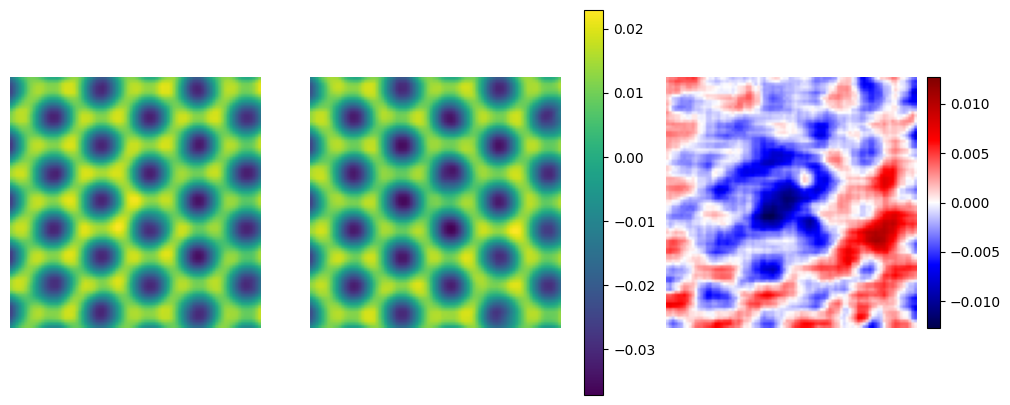

In [ ]:
from visualizers import plot_image_diffs
phase_base = ptycho_base.obj_model.obj[0,...].cpu().angle().detach().numpy()
phase_excited = ptycho_excited.obj_model.obj[0,...].cpu().angle().detach().numpy()

# there are weird alignment issues introduced, I assume its due to the padding 
# and the funny way we extrapolated the data
plot_image_diffs(
    phase_base[17:-15, 17:-15], 
    phase_excited[16:-16, 16:-16]
)

In [ ]:
# now do the same by getting the datasets from skips

In [9]:

# create a pixelated ptychography first, to fit the dft basis to.
probe_params = {
    "energy" : PROBE_ENERGY,
    "defocus" : PROBE_DEFOCUS,
    "semiangle_cutoff" : PROBE_SEMIANGLE, 
}
detector_model = DetectorPixelated() 

# Set up ptychography model for excited state
probe_model = ProbePixelated.from_params(
    num_probes=1,
    probe_params=probe_params,
)

obj_model = ObjectPixelated.from_uniform(
    num_slices=1, 
    slice_thicknesses=1,
    obj_type='pure_phase',
)
probe_model = ProbePixelated.from_params(
    num_probes=1,
    probe_params=probe_params,
)
ptycho = Ptychography.from_models(
    dset=pdset_base,
    obj_model=obj_model,
    probe_model=probe_model,
    detector_model=detector_model,
    device='cpu',
)
ptycho.preprocess( 
    obj_padding_px=(16, 16),
    batch_size=16,
)


In [22]:
lr = 1e-1
obj_lr = lr
probe_lr = lr

opt_params = { # except type, all args are passed to the optimizer (of type type)
    "object": {
        "type": "adam", 
        "lr": obj_lr
        , 
    },
    "probe": {
        "type": "adam", 
        "lr": probe_lr, 
    },
    # "dataset": { ### for optimizing over descan shifts and probe positions
    #     "type": "adam",
    #     "lr": 1e-4,
    # }
}

scheduler_params = {
    "object": { ## scheduler kwargs are passed to the scheduler (of type type)
        "type": "exp",
        "factor": 0.1,
        # "type": "plateau", ## i like plateau for many cases
    },
    "probe": {
        # "type": "exp",
        "type": "plateau",
        # "threshold": 1e-2, # e.g. plateau kwargs 
        # "patience": 100,
        # "cooldown": 100,
    },
    # "dataset": { 
    #     "type": "exp",  ## exp is also frequently used 
    #     "factor": 0.1,
    # }
}

constraints = {
    "object": {
        "tv_weight_yx": 1e-3, ## these are mostly the defaults 
        "tv_weight_z": 0.,
        "fix_potential_baseline": False,
        "identical_slices": True, ## default for this is False 
        "apply_fov_mask": False,
    },
    "probe": {
        "center_probe": False,
        "orthogonalize_probe": True,
    },
    "dataset":{
        "descan_tv_weight": 0,
        "descan_shifts_constant": False, 
    }
}


# ptycho.remove_optimizer("probe")
ptycho.reconstruct(
    num_iters=50,
    reset=True,
    autograd=True, 
    device='cpu',
    constraints=constraints, 
    optimizer_params=opt_params,
    scheduler_params=scheduler_params,
    batch_size=16,
) # .visualize()



  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\rotem.eli\Documents\colin colab\quantum multiobj fork\quantem\src\quantem\diffractive_imaging\object_models.py:385: UserWarning: calculating TV loss for phase, need to check phase wrapping. Easiest fix is scalar phase array.
  warn(
Iter 50/50, Loss: 8.765e-01: 100%|██████████| 50/50 [00:29<00:00,  1.68it/s]
